
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from plotnine import ggplot, aes, geom_point, geom_line, labs
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import get_scorer_names

In [ ]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [ ]:
ha['restecg'] = ha['restecg'].astype(str)
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)

In [ ]:
ha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   age      273 non-null    int64 
 1   sex      273 non-null    object
 2   cp       273 non-null    object
 3   trtbps   273 non-null    int64 
 4   chol     273 non-null    int64 
 5   restecg  273 non-null    object
 6   thalach  273 non-null    int64 
 7   output   273 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 17.2+ KB


In [ ]:
X = ha.drop(['cp'], axis = 1)
y = ha['cp']

enc = OneHotEncoder(sparse_output=False, handle_unknown = 'ignore')

ct = ColumnTransformer(
  [
    ("dummify",
    enc,
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

## KNN

In [ ]:
knn_pipeline = Pipeline([
    ('preprocessing', ct),
    ('classifier', KNeighborsClassifier())
]).set_output(transform = "pandas")

knn_param_grid = {
    'classifier__n_neighbors': np.arange(1, 31),  # Testing different numbers of neighbors
}

#grid search for cross validation
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='accuracy')

#fit to data
knn_grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('dummify',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7dfc700d0190>),
                                                                        ('standardize',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7dfc700d1d20>)])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
             scoring='accuracy')

In [ ]:
knn_grid_search.best_params_ , knn_grid_search.best_score_

({'classifier__n_neighbors': 20}, 0.5569696969696969)

In [ ]:
knn_best_model = knn_grid_search.best_estimator_.fit(X, y)

## Decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier()

#create a pipeline with preprocessing and the model
decision_tree_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', decision_tree)
])

#define param grid
decision_tree_param_grid = {
    'classifier__max_depth': [None] + list(range(1, 11)),
    'classifier__min_samples_split': range(2, 11),
    'classifier__min_samples_leaf': range(1, 11)
}

#grid search
decision_tree_grid_search = GridSearchCV(decision_tree_pipeline, decision_tree_param_grid, cv=5, scoring='accuracy')

#fit to data
decision_tree_grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('dummify',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7dfc700d0190>),
                                                                        ('standardize',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7dfc700d1d20>)])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8,
                                                   9, 10],
                         'classifier__min_samples_leaf': range(1, 11),
                         'classifier__min_samples_split': range(2, 11)},
             scoring='accuracy')

In [ ]:
decision_tree_grid_search.best_params_ , decision_tree_grid_search.best_score_

({'classifier__max_depth': 1,
  'classifier__min_samples_leaf': 1,
  'classifier__min_samples_split': 2},
 0.5752188552188552)

In [ ]:
decision_tree_best_model = decision_tree_grid_search.best_estimator_.fit(X, y)

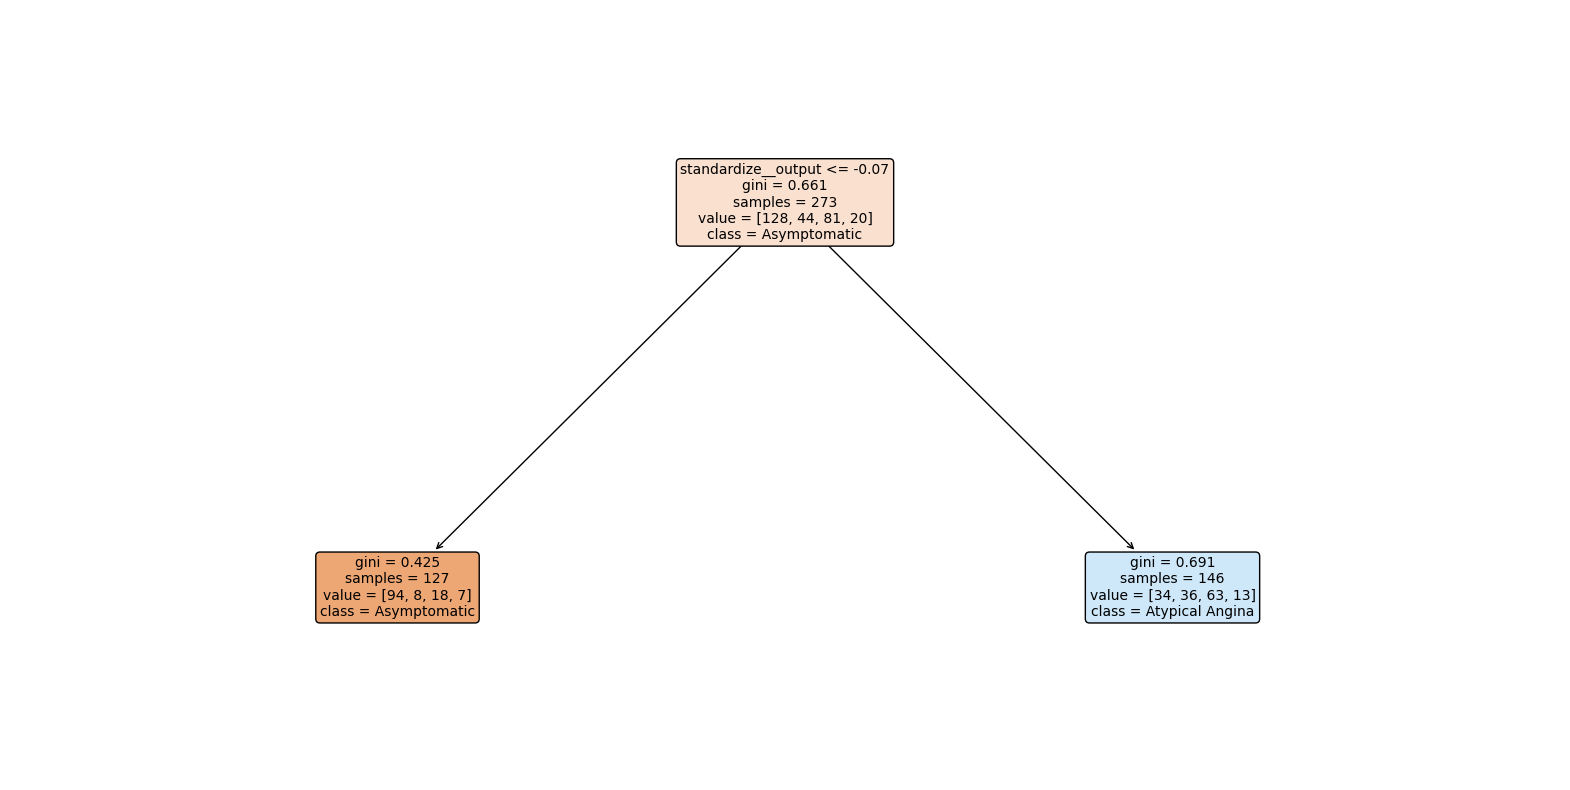

In [ ]:
#extract feature names from ColumnTransformer
feature_names = decision_tree_grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

best_decision_tree_model_plot = decision_tree_grid_search.best_estimator_.named_steps['classifier']

#plot decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_decision_tree_model_plot,
          feature_names=feature_names,
          class_names=["Asymptomatic", "Typical Angina", "Atypical Angina", "Non-Anginal Pain"],
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

## LDA

In [ ]:
#create a pipeline with preprocessing and the model
lda_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', LinearDiscriminantAnalysis())
])


#define param grid
lda_param_grid = {
    'classifier__solver': ['svd', 'lsqr']
}

#grid search
lda_grid_search = GridSearchCV(lda_pipeline, lda_param_grid, cv=5, scoring='accuracy')

#fit to data
lda_grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('dummify',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7dfc700d0190>),
                                                                        ('standardize',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7dfc700d1d20>)])),
                                       ('classifier',
                                        LinearDiscriminantAnalysis())]),
             param_grid={'classifier__solver': ['svd', 'lsqr']},
             scoring='accuracy')

In [ ]:
lda_grid_search.best_params_ , lda_grid_search.best_score_

({'classifier__solver': 'svd'}, 0.5312457912457912)

In [ ]:
lda_best_model = lda_grid_search.best_estimator_.fit(X, y)

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [ ]:
ha['cp_is_3'] = (ha['cp'] == "3").astype(int)
ha['cp_is_0'] = (ha['cp'] == "0").astype(int)
ha['cp_is_1'] = (ha['cp'] == "1").astype(int)
ha['cp_is_2'] = (ha['cp'] == "2").astype(int)

In [ ]:
X = ha.drop(['cp','cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis = 1)

In [ ]:
y = ha['cp_is_3']

log_reg = LogisticRegression()

#create a pipeline with preprocessing and the model
log_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', log_reg)
])

#define parameter grid for hyperparameter tuning
log_param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),  # Testing a range of regularization strengths
    'classifier__solver': ['liblinear', 'lbfgs']  # Different algorithms for optimization
}

#grid search
log_reg_grid_search = GridSearchCV(log_pipeline, log_param_grid, cv=5, scoring='f1')

#fit to data
log_reg_grid_search.fit(X, y)

log_reg_grid_search.best_params_ , log_reg_grid_search.best_score_

({'classifier__C': 0.0001, 'classifier__solver': 'liblinear'}, 0.0)

In [ ]:
y = ha['cp_is_0']

log_reg = LogisticRegression()

#create a pipeline with preprocessing and the model
log_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', log_reg)
])

#define parameter grid for hyperparameter tuning
log_param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),  # Testing a range of regularization strengths
    'classifier__solver': ['liblinear', 'lbfgs']  # Different algorithms for optimization
}

#grid search
log_reg_grid_search = GridSearchCV(log_pipeline, log_param_grid, cv=5, scoring='f1')

#fit to data
log_reg_grid_search.fit(X, y)

log_reg_grid_search.best_params_ , log_reg_grid_search.best_score_

({'classifier__C': 0.004832930238571752, 'classifier__solver': 'liblinear'},
 0.6603187169224906)

In [ ]:
y = ha['cp_is_1']

log_reg = LogisticRegression()

#create a pipeline with preprocessing and the model
log_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', log_reg)
])

#define parameter grid for hyperparameter tuning
log_param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),  # Testing a range of regularization strengths
    'classifier__solver': ['liblinear', 'lbfgs']  # Different algorithms for optimization
}

#grid search
log_reg_grid_search = GridSearchCV(log_pipeline, log_param_grid, cv=5, scoring='f1')

#fit to data
log_reg_grid_search.fit(X, y)

log_reg_grid_search.best_params_ , log_reg_grid_search.best_score_

({'classifier__C': 0.0001, 'classifier__solver': 'liblinear'}, 0.0)

In [ ]:
y = ha['cp_is_2']

log_reg = LogisticRegression()

#create a pipeline with preprocessing and the model
log_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', log_reg)
])

#define parameter grid for hyperparameter tuning
log_param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),  # Testing a range of regularization strengths
    'classifier__solver': ['liblinear', 'lbfgs']  # Different algorithms for optimization
}

#grid search
log_reg_grid_search = GridSearchCV(log_pipeline, log_param_grid, cv=5, scoring='f1')

#fit to data
log_reg_grid_search.fit(X, y)

log_reg_grid_search.best_params_ , log_reg_grid_search.best_score_

({'classifier__C': 0.23357214690901212, 'classifier__solver': 'lbfgs'},
 0.14140589569160994)

The model was best at distinguishing cp_is_0 which makes sense in a OVR since it is the absence of chest pain.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [ ]:
ha_filtered_0_1 = ha[(ha['cp'] == "0") | (ha['cp'] == "1")]
ha_filtered_0_2 = ha[(ha['cp'] == "0") | (ha['cp'] == "2")]
ha_filtered_0_3 = ha[(ha['cp'] == "0") | (ha['cp'] == "3")]

In [ ]:
X = ha_filtered_0_1.drop(['cp','cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis = 1)
y = ha_filtered_0_1['cp']

log_reg = LogisticRegression()

#create a pipeline with preprocessing and the model
log_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', log_reg)
])

#define parameter grid for hyperparameter tuning
log_param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),  # Testing a range of regularization strengths
    'classifier__solver': ['liblinear', 'lbfgs']  # Different algorithms for optimization
}

#grid search
log_reg_grid_search = GridSearchCV(log_pipeline, log_param_grid, cv=5, scoring='roc_auc')

#fit to data
log_reg_grid_search.fit(X, y)

log_reg_grid_search.best_params_ , log_reg_grid_search.best_score_

({'classifier__C': 0.08858667904100823, 'classifier__solver': 'lbfgs'},
 0.8476367521367522)

In [ ]:
X = ha_filtered_0_2.drop(['cp','cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis = 1)
y = ha_filtered_0_2['cp']

log_reg = LogisticRegression()

#create a pipeline with preprocessing and the model
log_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', log_reg)
])

#define parameter grid for hyperparameter tuning
log_param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),  # Testing a range of regularization strengths
    'classifier__solver': ['liblinear', 'lbfgs']  # Different algorithms for optimization
}

#grid search
log_reg_grid_search = GridSearchCV(log_pipeline, log_param_grid, cv=5, scoring='roc_auc')

#fit to data
log_reg_grid_search.fit(X, y)

log_reg_grid_search.best_params_ , log_reg_grid_search.best_score_

({'classifier__C': 0.0018329807108324356, 'classifier__solver': 'lbfgs'},
 0.761037330316742)

In [ ]:
X = ha_filtered_0_3.drop(['cp','cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis = 1)
y = ha_filtered_0_3['cp']

log_reg = LogisticRegression()

#create a pipeline with preprocessing and the model
log_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', log_reg)
])

#define parameter grid for hyperparameter tuning
log_param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),  # Testing a range of regularization strengths
    'classifier__solver': ['liblinear', 'lbfgs']  # Different algorithms for optimization
}

#grid search
log_reg_grid_search = GridSearchCV(log_pipeline, log_param_grid, cv=5, scoring='roc_auc')

#fit to data
log_reg_grid_search.fit(X, y)

log_reg_grid_search.best_params_ , log_reg_grid_search.best_score_

({'classifier__C': 1.623776739188721, 'classifier__solver': 'lbfgs'},
 0.7411538461538462)

The pair that OvO was best at distinguishing was 0 and 1.